In [42]:
#auto reload modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [43]:
import os.path as osp
import random
from typing import Dict,List

import gym.spaces as spaces
import hydra
import numpy as np
import torch
from hydra.utils import instantiate as hydra_instantiate
from omegaconf import DictConfig
from rl_utils.envs import create_vectorized_envs
from rl_utils.logging import Logger
from tensordict.tensordict import TensorDict
from torchrl.envs.utils import step_mdp
from typing import Tuple
from imitation_learning.common.evaluator import Evaluator

In [44]:
from snake_env import SnakeEnv 

In [45]:
import yaml 
cfg = yaml.load(open("bc-irl-snake.yaml", 'r'), Loader=yaml.SafeLoader)
cfg = DictConfig(cfg)

In [46]:
cfg

{'env_settings': {}, 'obs_shape': '???', 'action_dim': '???', 'total_num_updates': '???', 'action_is_discrete': '???', 'num_steps': 50, 'num_envs': 256, 'device': 'cpu', 'only_eval': False, 'seed': 3, 'num_eval_episodes': 100, 'num_env_steps': 5000000, 'recurrent_hidden_state_size': 128, 'gamma': 0.99, 'log_interval': 10, 'eval_interval': 500, 'save_interval': 10000000000, 'load_checkpoint': None, 'load_policy': True, 'resume_training': False, 'policy': {'_target_': 'imitation_learning.policy_opt.policy.Policy', 'hidden_size': 128, 'recurrent_hidden_size': 128, 'is_recurrent': False, 'obs_shape': '${obs_shape}', 'action_dim': '${action_dim}', 'action_is_discrete': '${action_is_discrete}', 'std_init': 0, 'num_envs': '${num_envs}'}, 'policy_updater': {'_target_': 'imitation_learning.bcirl.BCIRL', '_recursive_': False, 'use_clipped_value_loss': True, 'clip_param': 0.2, 'value_loss_coef': 0.5, 'entropy_coef': 0.0001, 'max_grad_norm': 0.5, 'num_epochs': 2, 'num_mini_batch': 4, 'num_envs': '

In [47]:

def set_seed(seed: int) -> None:
    """
    Sets the seed for numpy, python random, and pytorch.
    """
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)

In [48]:
from gymnasium import Env
class vectorized_env():
    def __init__(self, envs : List[Env]):
        self.envs = envs
        self.num_envs = len(self.envs)
        self.observation_space = self.envs[0].observation_space
        self.action_space = self.envs[0].action_space

    def reset(self):

        return torch.tensor([env.reset()[0].tolist() for env in self.envs],dtype=torch.float32)
    
    def step(self, action) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, List[Dict]]:
        steps = [env.step(action[i]) for i,env in enumerate(self.envs)]
        return_value = (torch.tensor([step[0].tolist() for step in steps],dtype=torch.float32),
                torch.tensor([step[1] for step in steps],dtype=torch.float32),
                torch.tensor([step[2] for step in steps],dtype=torch.bool),
                [step[3] for step in steps])
        return return_value
    
    def render(self, mode = "rgb_array"):
        if(self.envs[0].render_mode == "rgb_array"):
            return [env.render(mode) for env in self.envs]
        else:
            self.envs[0].render(mode)

In [49]:
set_seed(cfg.seed)

device = torch.device(cfg.device)

# Setup the environments
set_env_settings = {
    k: hydra_instantiate(v) if isinstance(v, DictConfig) else v
    for k, v in cfg.env.env_settings.items()
}
envs = vectorized_env([SnakeEnv(cfg.env.env_settings.params.config) for _ in range(cfg.num_envs)])

steps_per_update = cfg.num_steps * cfg.num_envs

num_updates = int(cfg.num_env_steps) // steps_per_update

# Set dynamic variables in the config.
cfg.obs_shape = envs.observation_space.shape
cfg.action_dim = envs.action_space.shape[0]
cfg.action_is_discrete = isinstance(cfg.action_dim, spaces.Discrete)
cfg.total_num_updates = num_updates

logger: Logger = hydra_instantiate(cfg.logger, full_cfg=cfg)
print("policy",cfg.policy)
policy = hydra_instantiate(cfg.policy)
policy = policy.to(device)
print("policy_updater",cfg.policy_updater)
updater = hydra_instantiate(cfg.policy_updater, policy=policy, device=device)


Assigning full prefix 63-3-N9wNPS
policy {'_target_': 'imitation_learning.policy_opt.policy.Policy', 'hidden_size': 128, 'recurrent_hidden_size': 128, 'is_recurrent': False, 'obs_shape': [10], 'action_dim': 4, 'action_is_discrete': False, 'std_init': 0, 'num_envs': 256}
policy_updater {'_target_': 'imitation_learning.bcirl.BCIRL', '_recursive_': False, 'use_clipped_value_loss': True, 'clip_param': 0.2, 'value_loss_coef': 0.5, 'entropy_coef': 0.0001, 'max_grad_norm': 0.5, 'num_epochs': 2, 'num_mini_batch': 4, 'num_envs': '${num_envs}', 'num_steps': '${num_steps}', 'gae_lambda': 0.95, 'gamma': '${gamma}', 'optimizer_params': {'_target_': 'torch.optim.Adam', 'lr': 0.0003}, 'batch_size': 256, 'plot_interval': '${eval_interval}', 'norm_expert_actions': False, 'n_inner_iters': 1, 'reward_update_freq': 1, 'device': '${device}', 'total_num_updates': '${total_num_updates}', 'use_lr_decay': False, 'get_dataset_fn': {'_target_': 'imitation_learning.common.utils.get_transition_dataset', 'dataset_p

In [50]:

start_update = 0
if cfg.load_checkpoint is not None:
    # Load a checkpoint for the policy/reward. Also potentially resume
    # training.
    ckpt = torch.load(cfg.load_checkpoint)
    updater.load_state_dict(ckpt["updater"], should_load_opt=cfg.resume_training)
    if cfg.load_policy:
        policy.load_state_dict(ckpt["policy"])
    if cfg.resume_training:
        start_update = ckpt["update_i"] + 1

eval_info = {"run_name": logger.run_name}


In [51]:
import warnings 
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

tensor([0.1000, 0.9000, 0.2000, 0.8000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000])

Updates 0, Steps 12800, FPS 5165
Over the last 10 episodes:
    - episode.reward: 0.2810620311326527
    - episode.score: 0.0
    - episode.distance_to_goal: 0.35378302526996147
    - inferred_episode_reward: -1.0070867538452148
    - value_loss: 0.987041212618351
    - action_loss: 0.00325221277307719
    - dist_entropy: 5.675752639770508
    - irl_loss: 0.3669171631336212


<Figure size 640x480 with 0 Axes>

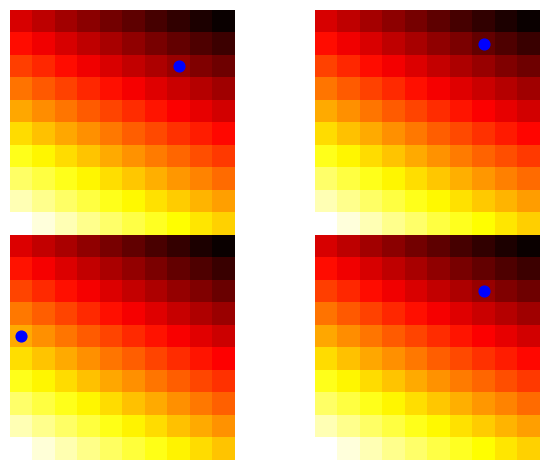


Updates 10, Steps 140800, FPS 7305
Over the last 10 episodes:
    - episode.reward: 0.31261652544008384
    - episode.score: 0.0
    - episode.distance_to_goal: 0.374959814772294
    - inferred_episode_reward: 1.511951558291912
    - value_loss: 1.6058815956115722
    - action_loss: -0.0010124870750587434
    - dist_entropy: 5.67535400390625
    - irl_loss: 0.34061490595340727


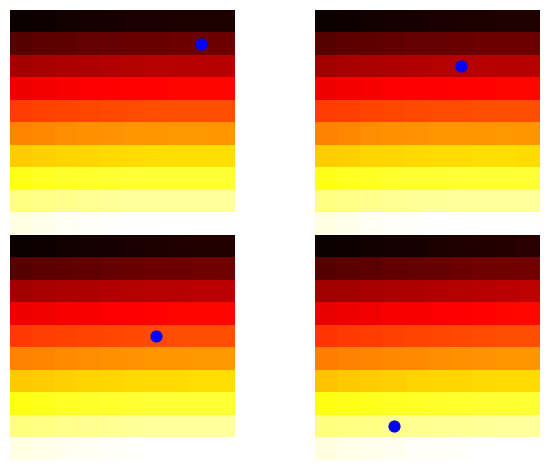


Updates 20, Steps 268800, FPS 8112
Over the last 10 episodes:
    - episode.reward: 0.061583807470362205
    - episode.score: 0.0
    - episode.distance_to_goal: 0.4669985858811379
    - inferred_episode_reward: 6.083794510364532
    - value_loss: 5.880114316940308
    - action_loss: 0.00053875339217484
    - dist_entropy: 5.677114009857178
    - irl_loss: 0.30976749360561373


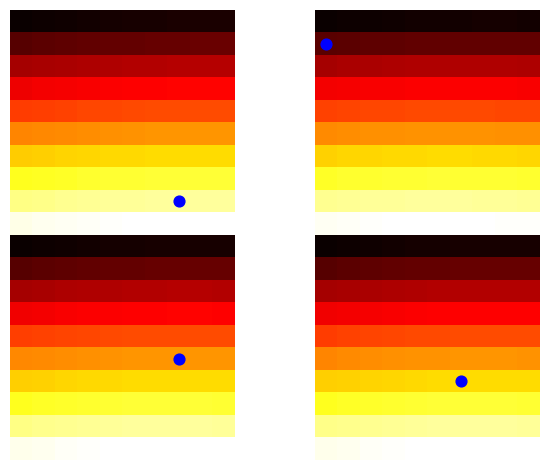


Updates 30, Steps 396800, FPS 7649
Over the last 10 episodes:
    - episode.reward: 0.20829584367277176
    - episode.score: 0.0
    - episode.distance_to_goal: 0.46544573187682525
    - inferred_episode_reward: 7.0845973014831545
    - value_loss: 10.67040195465088
    - action_loss: -0.004782376292860135
    - dist_entropy: 5.675832939147949
    - irl_loss: 0.2916546106338501


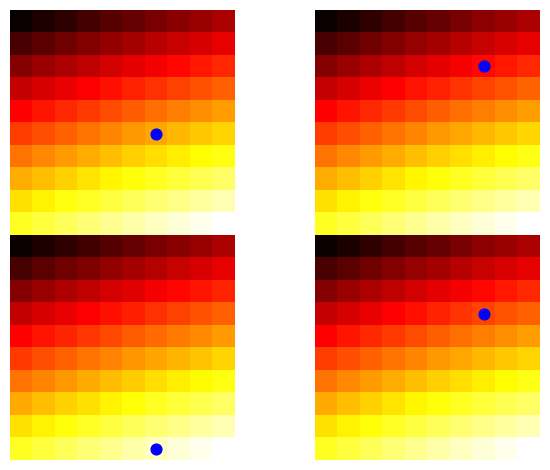


Updates 40, Steps 524800, FPS 7493
Over the last 10 episodes:
    - episode.reward: 0.03912090939136514
    - episode.score: 0.0
    - episode.distance_to_goal: 0.4098629070811241
    - inferred_episode_reward: 6.551737689971924
    - value_loss: 17.628999137878417
    - action_loss: -0.003949096810538321
    - dist_entropy: 5.675314331054688
    - irl_loss: 0.27264663577079773


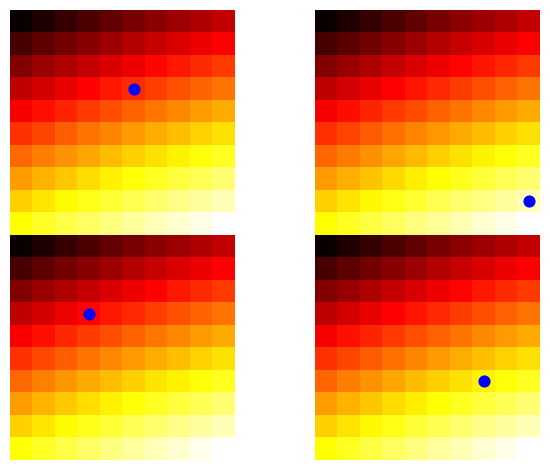


Updates 50, Steps 652800, FPS 8379
Over the last 10 episodes:
    - episode.reward: 0.12377629144950002
    - episode.score: 0.0
    - episode.distance_to_goal: 0.3939134294523242
    - inferred_episode_reward: 9.302629101276398
    - value_loss: 17.61078643798828
    - action_loss: 0.009343139489647
    - dist_entropy: 5.6751556396484375
    - irl_loss: 0.2742476910352707


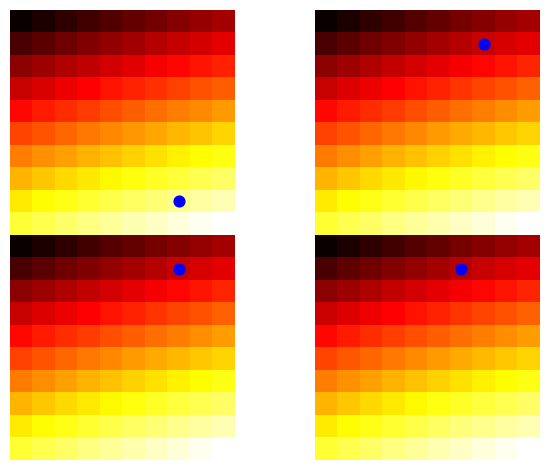


Updates 60, Steps 780800, FPS 8204
Over the last 10 episodes:
    - episode.reward: 0.09566021599789823
    - episode.score: 0.0
    - episode.distance_to_goal: 0.3682707227435541
    - inferred_episode_reward: 6.620737159252167
    - value_loss: 22.76791591644287
    - action_loss: -0.0016449212329462171
    - dist_entropy: 5.674954414367676
    - irl_loss: 0.2724138230085373


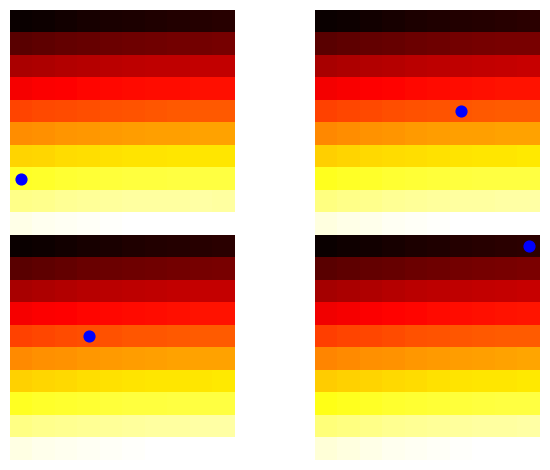


Updates 70, Steps 908800, FPS 8088
Over the last 10 episodes:
    - episode.reward: 0.15416124247742263
    - episode.score: 0.0
    - episode.distance_to_goal: 0.3917762407271684
    - inferred_episode_reward: 15.790193319320679
    - value_loss: 30.5734806060791
    - action_loss: 0.00534967528656125
    - dist_entropy: 5.6741537094116214
    - irl_loss: 0.26656346768140793


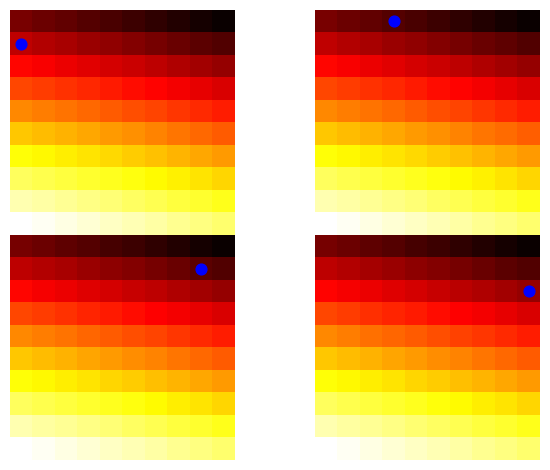


Updates 80, Steps 1036800, FPS 7933
Over the last 10 episodes:
    - episode.reward: 0.07125934922866846
    - episode.score: 0.0
    - episode.distance_to_goal: 0.39927438032505375
    - inferred_episode_reward: 9.065825128555298
    - value_loss: 21.87529754638672
    - action_loss: -0.012059192324522882
    - dist_entropy: 5.674794387817383
    - irl_loss: 0.2688616022467613


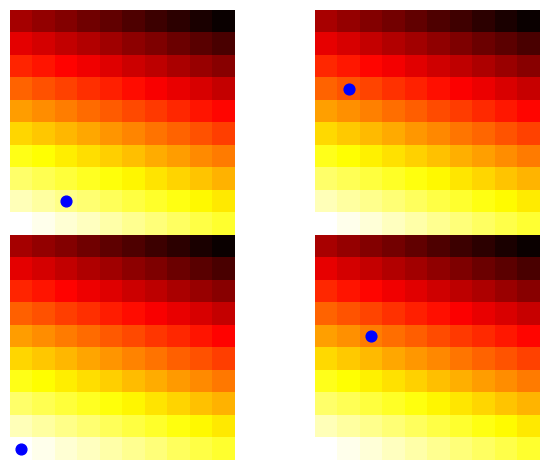


Updates 90, Steps 1164800, FPS 7678
Over the last 10 episodes:
    - episode.reward: -0.1
    - episode.score: 0.0
    - episode.distance_to_goal: 0.3415916292961253
    - inferred_episode_reward: 13.217784070968628
    - value_loss: 35.91775817871094
    - action_loss: 0.002828943554777652
    - dist_entropy: 5.6755523681640625
    - irl_loss: 0.2703677386045456


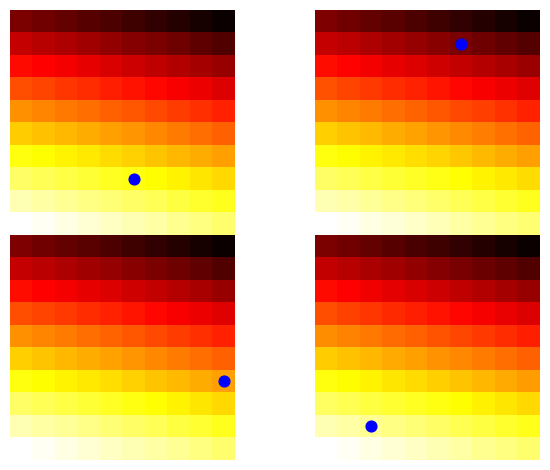


Updates 100, Steps 1292800, FPS 7553
Over the last 10 episodes:
    - episode.reward: 0.2598643044904736
    - episode.score: 0.0
    - episode.distance_to_goal: 0.44449107435749485
    - inferred_episode_reward: 16.541834139823912
    - value_loss: 51.045155715942386
    - action_loss: 0.0043457520194351675
    - dist_entropy: 5.675832939147949
    - irl_loss: 0.2661697581410408


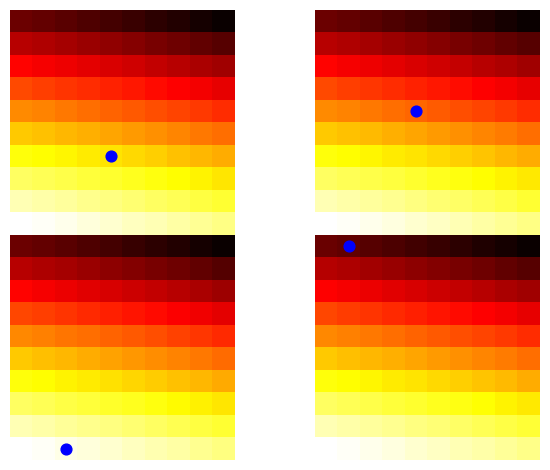


Updates 110, Steps 1420800, FPS 7925
Over the last 10 episodes:
    - episode.reward: 1.1568116949220202
    - episode.score: 0.1
    - episode.distance_to_goal: 0.4075016983413298
    - inferred_episode_reward: 31.116514682769775
    - value_loss: 57.682260513305664
    - action_loss: -0.0004770987667143345
    - dist_entropy: 5.6765542984008786
    - irl_loss: 0.25331354439258574


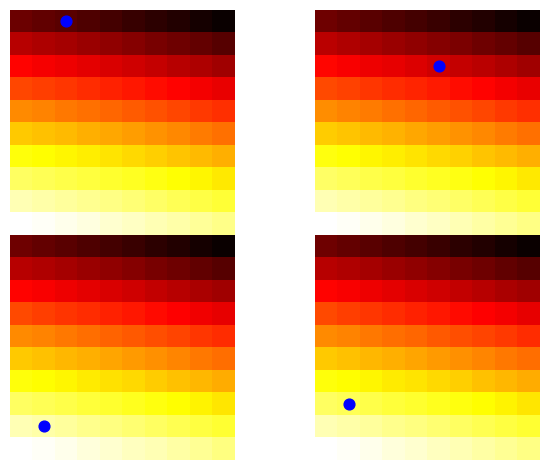


Updates 120, Steps 1548800, FPS 7791
Over the last 10 episodes:
    - episode.reward: 0.18878679656440356
    - episode.score: 0.0
    - episode.distance_to_goal: 0.37427169509650277
    - inferred_episode_reward: 9.622479343414307
    - value_loss: 56.67526435852051
    - action_loss: 0.0005094193853437901
    - dist_entropy: 5.6765130996704105
    - irl_loss: 0.25039614289999007


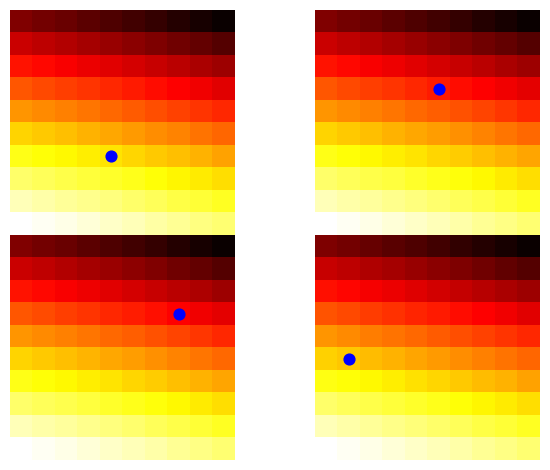


Updates 130, Steps 1676800, FPS 7416
Over the last 10 episodes:
    - episode.reward: -0.13099019513592786
    - episode.score: 0.0
    - episode.distance_to_goal: 0.41961229277971707
    - inferred_episode_reward: 19.750586438179017
    - value_loss: 55.27301559448242
    - action_loss: 0.0008584598544985056
    - dist_entropy: 5.675433731079101
    - irl_loss: 0.25214479118585587


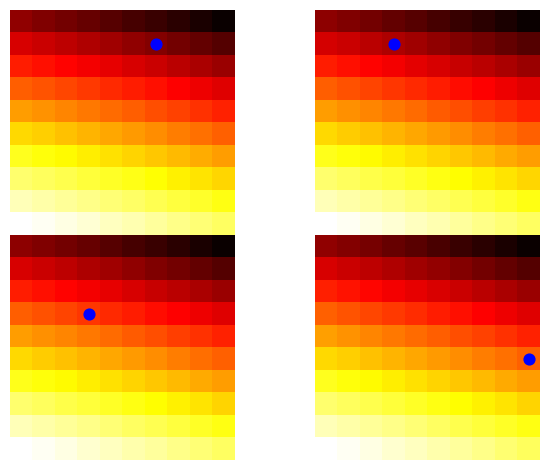


Updates 140, Steps 1804800, FPS 8599
Over the last 10 episodes:
    - episode.reward: 0.2553387291635024
    - episode.score: 0.0
    - episode.distance_to_goal: 0.38569636723825307
    - inferred_episode_reward: 23.736064732074738
    - value_loss: 48.62455940246582
    - action_loss: 0.0035244675781541447
    - dist_entropy: 5.675592422485352
    - irl_loss: 0.24760694205760955


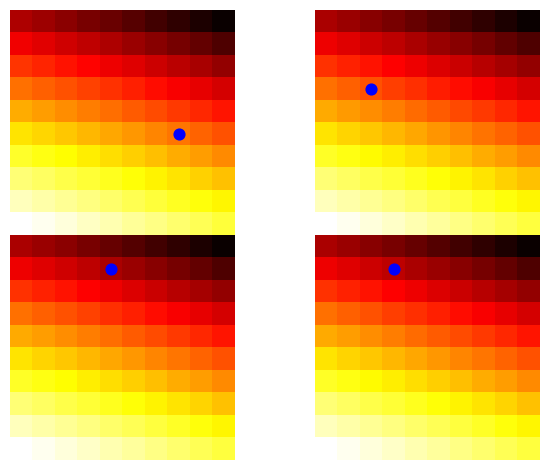


Updates 150, Steps 1932800, FPS 8325
Over the last 10 episodes:
    - episode.reward: 0.24620277836399396
    - episode.score: 0.0
    - episode.distance_to_goal: 0.34957921161235034
    - inferred_episode_reward: 9.769462823867798
    - value_loss: 45.09873275756836
    - action_loss: 0.000824119703611359
    - dist_entropy: 5.674553871154785
    - irl_loss: 0.24795736819505693


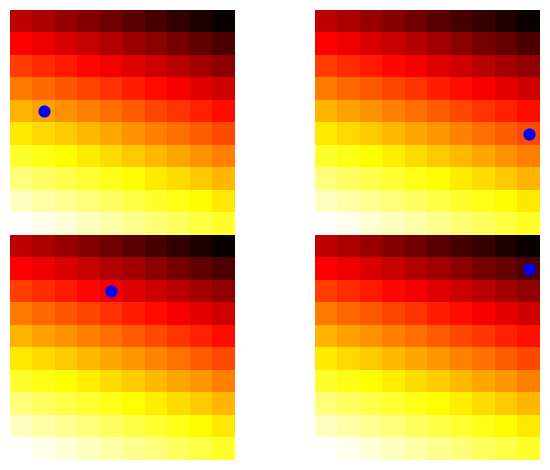


Updates 160, Steps 2060800, FPS 8575
Over the last 10 episodes:
    - episode.reward: 0.2846428100518439
    - episode.score: 0.0
    - episode.distance_to_goal: 0.38821045585122105
    - inferred_episode_reward: 19.18866420984268
    - value_loss: 40.06229133605957
    - action_loss: 0.005651536065852269
    - dist_entropy: 5.674714088439941
    - irl_loss: 0.24448134005069733


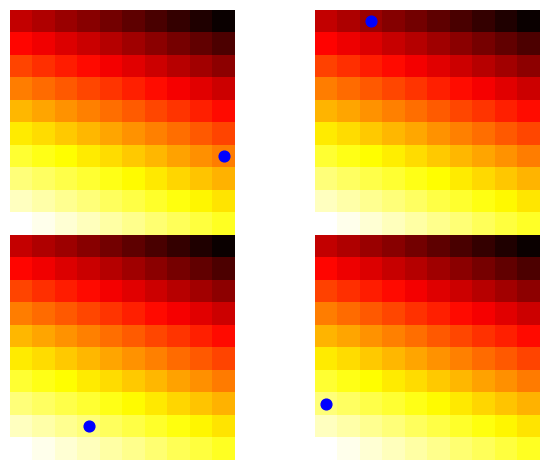


Updates 170, Steps 2188800, FPS 6916
Over the last 10 episodes:
    - episode.reward: 0.2842995845227246
    - episode.score: 0.0
    - episode.distance_to_goal: 0.41850064055659086
    - inferred_episode_reward: 10.50997840166092
    - value_loss: 42.182363510131836
    - action_loss: 0.00013448289246298373
    - dist_entropy: 5.67535400390625
    - irl_loss: 0.24384821355342864


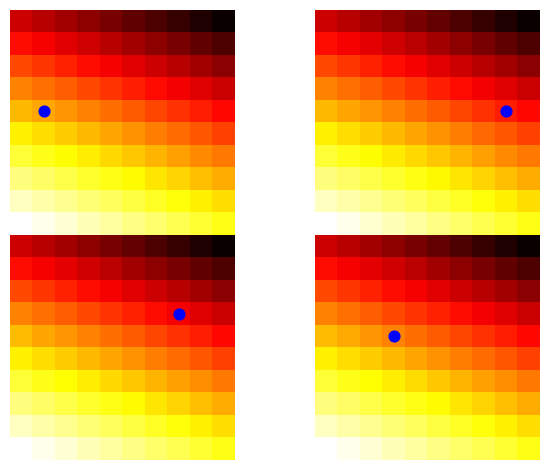


Updates 180, Steps 2316800, FPS 7355
Over the last 10 episodes:
    - episode.reward: 0.07349718460127116
    - episode.score: 0.0
    - episode.distance_to_goal: 0.3891740072884299
    - inferred_episode_reward: 13.28891179561615
    - value_loss: 34.8436637878418
    - action_loss: -0.001868110557552427
    - dist_entropy: 5.6747541427612305
    - irl_loss: 0.23928698599338533


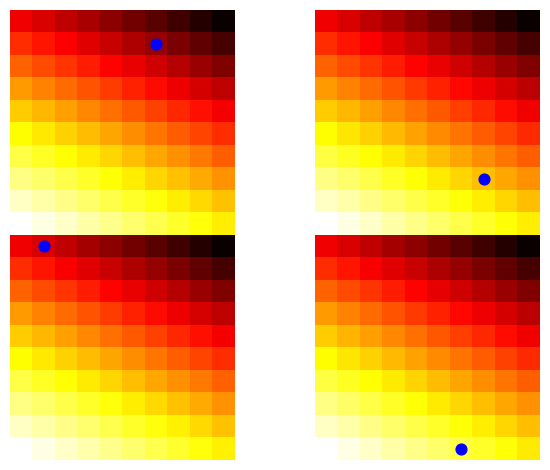


Updates 190, Steps 2444800, FPS 8221
Over the last 10 episodes:
    - episode.reward: 0.28293919019191016
    - episode.score: 0.0
    - episode.distance_to_goal: 0.339440742871404
    - inferred_episode_reward: 14.696333026885986
    - value_loss: 23.927882194519043
    - action_loss: -0.006673783110454678
    - dist_entropy: 5.673953056335449
    - irl_loss: 0.24491271376609802


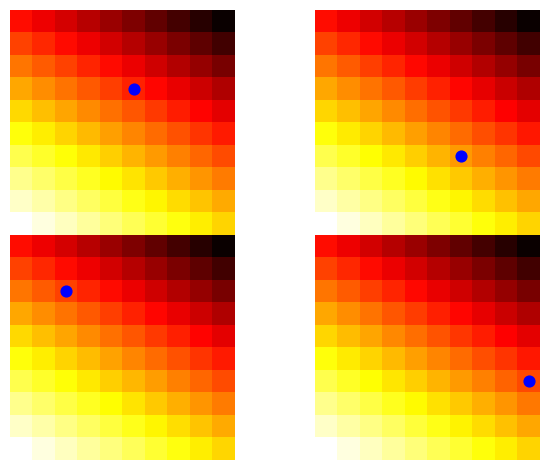


Updates 200, Steps 2572800, FPS 8920
Over the last 10 episodes:
    - episode.reward: 0.4601605679237302
    - episode.score: 0.0
    - episode.distance_to_goal: 0.28353255029659463
    - inferred_episode_reward: 14.813188576698304
    - value_loss: 20.83622455596924
    - action_loss: -0.006425179447978735
    - dist_entropy: 5.673550605773926
    - irl_loss: 0.2535643666982651


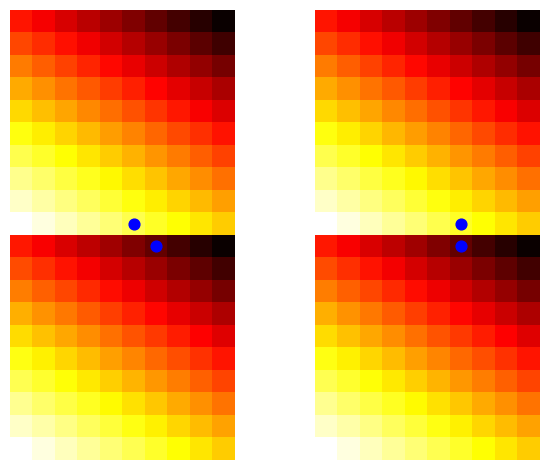


Updates 210, Steps 2700800, FPS 7537
Over the last 10 episodes:
    - episode.reward: -0.036588924376752194
    - episode.score: 0.0
    - episode.distance_to_goal: 0.39274865100779743
    - inferred_episode_reward: 13.528758132457734
    - value_loss: 28.62829246520996
    - action_loss: 0.00025155148468911646
    - dist_entropy: 5.674109935760498
    - irl_loss: 0.2569308280944824


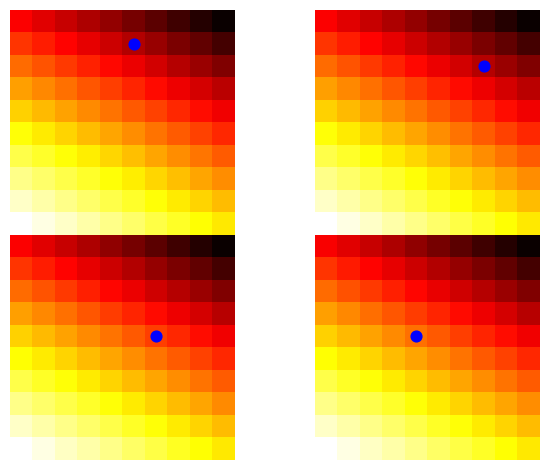


Updates 220, Steps 2828800, FPS 7061
Over the last 10 episodes:
    - episode.reward: 0.08134776584271516
    - episode.score: 0.0
    - episode.distance_to_goal: 0.4248241754113655
    - inferred_episode_reward: 14.179404783248902
    - value_loss: 38.01764183044433
    - action_loss: -0.003304378531174734
    - dist_entropy: 5.674230003356934
    - irl_loss: 0.2660249561071396


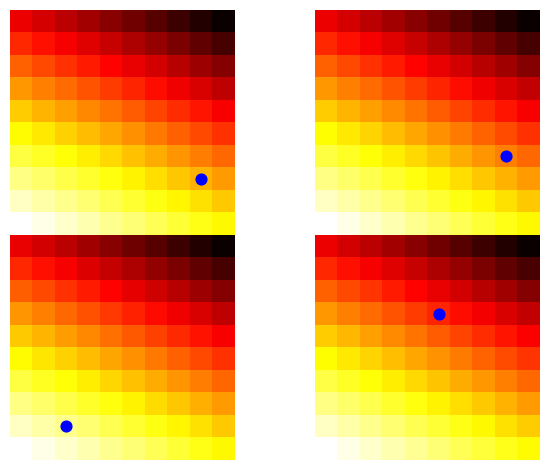


Updates 230, Steps 2956800, FPS 6910
Over the last 10 episodes:
    - episode.reward: 0.043524409655930504
    - episode.score: 0.0
    - episode.distance_to_goal: 0.37616479659829344
    - inferred_episode_reward: 21.547735071182252
    - value_loss: 37.98209419250488
    - action_loss: -0.0022387648037692997
    - dist_entropy: 5.674309825897216
    - irl_loss: 0.2689403623342514


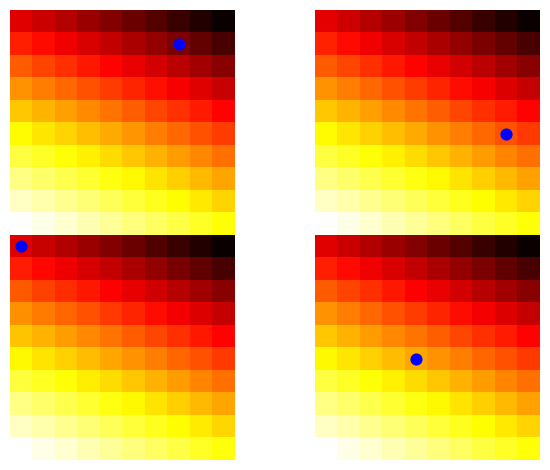


Updates 240, Steps 3084800, FPS 9760
Over the last 10 episodes:
    - episode.reward: 0.24949447720382167
    - episode.score: 0.0
    - episode.distance_to_goal: 0.3564653769537763
    - inferred_episode_reward: 11.18767499923706
    - value_loss: 35.62549667358398
    - action_loss: -0.0029552852851338685
    - dist_entropy: 5.673509120941162
    - irl_loss: 0.26440739929676055


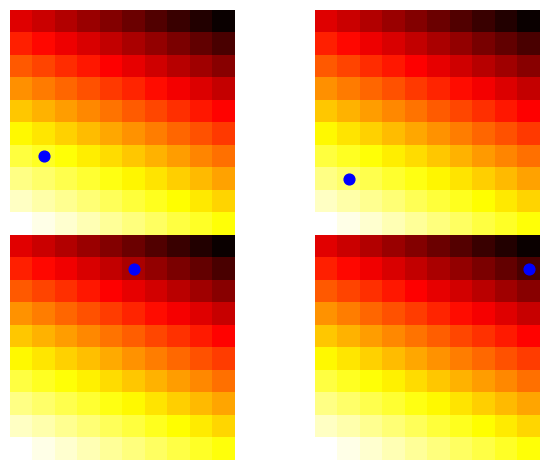


Updates 250, Steps 3212800, FPS 10881
Over the last 10 episodes:
    - episode.reward: 0.0734062098040851
    - episode.score: 0.0
    - episode.distance_to_goal: 0.4120922225686465
    - inferred_episode_reward: 5.928176274895668
    - value_loss: 12.875299644470214
    - action_loss: 0.0001892387750558555
    - dist_entropy: 5.674108028411865
    - irl_loss: 0.264587527513504


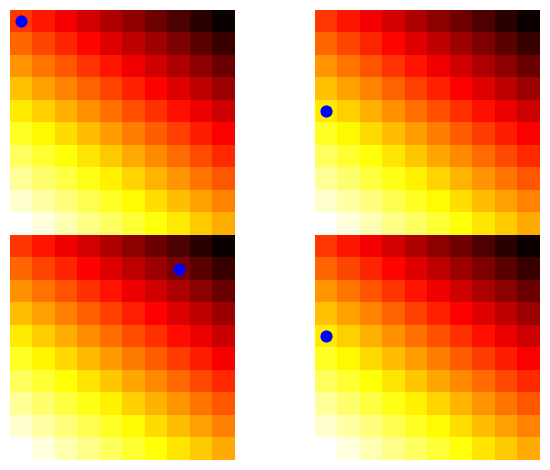


Updates 260, Steps 3340800, FPS 11081
Over the last 10 episodes:
    - episode.reward: 0.048058265625168635
    - episode.score: 0.0
    - episode.distance_to_goal: 0.44530500478381213
    - inferred_episode_reward: 7.994987541437149
    - value_loss: 10.676306915283202
    - action_loss: -0.0006569313816726207
    - dist_entropy: 5.674148178100586
    - irl_loss: 0.2673387974500656


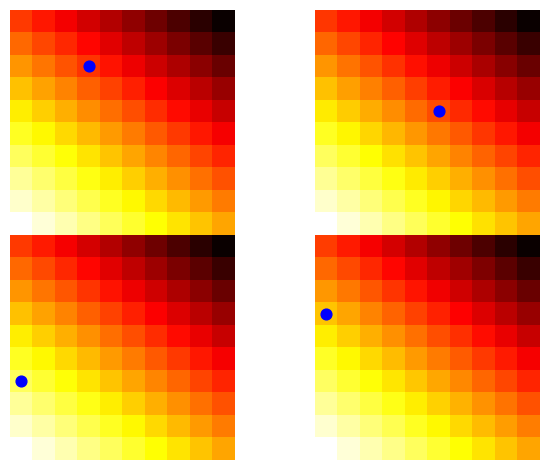


Updates 270, Steps 3468800, FPS 10897
Over the last 10 episodes:
    - episode.reward: 0.21849548252582593
    - episode.score: 0.0
    - episode.distance_to_goal: 0.3744128904862689
    - inferred_episode_reward: 8.728090167045593
    - value_loss: 18.33448314666748
    - action_loss: 0.0006830082274973392
    - dist_entropy: 5.674908256530761
    - irl_loss: 0.27094616293907164


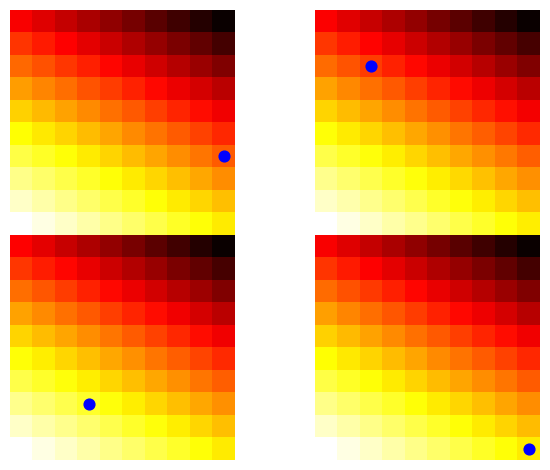


Updates 280, Steps 3596800, FPS 11525
Over the last 10 episodes:
    - episode.reward: 0.3463072045706756
    - episode.score: 0.0
    - episode.distance_to_goal: 0.3560016398402544
    - inferred_episode_reward: 9.688832879066467
    - value_loss: 23.636898612976076
    - action_loss: 0.0034196174121461807
    - dist_entropy: 5.6755876541137695
    - irl_loss: 0.2708935409784317


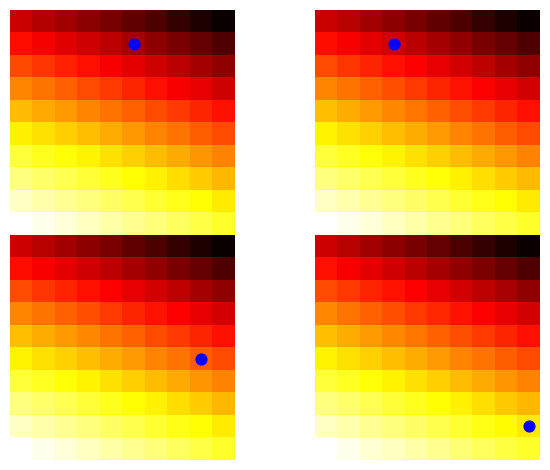


Updates 290, Steps 3724800, FPS 11052
Over the last 10 episodes:
    - episode.reward: -0.04063226475001447
    - episode.score: 0.0
    - episode.distance_to_goal: 0.37526219416796713
    - inferred_episode_reward: 13.974436348676681
    - value_loss: 25.12597370147705
    - action_loss: 0.0046277045388706025
    - dist_entropy: 5.675787830352784
    - irl_loss: 0.26572861075401305


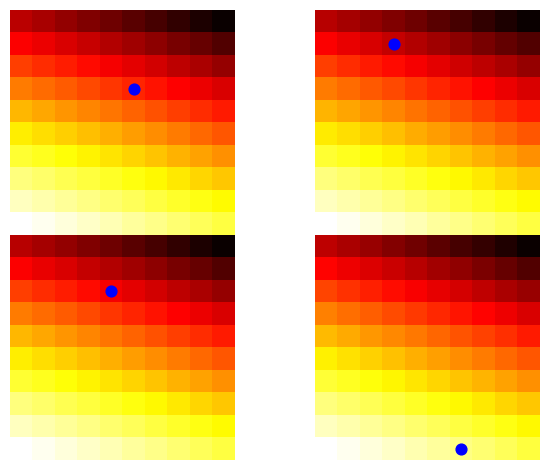


Updates 300, Steps 3852800, FPS 10398
Over the last 10 episodes:
    - episode.reward: 0.15913163050882745
    - episode.score: 0.0
    - episode.distance_to_goal: 0.3517645447150256
    - inferred_episode_reward: 8.245972895622254
    - value_loss: 24.515377235412597
    - action_loss: 0.003934435965493322
    - dist_entropy: 5.6763073921203615
    - irl_loss: 0.2715983957052231


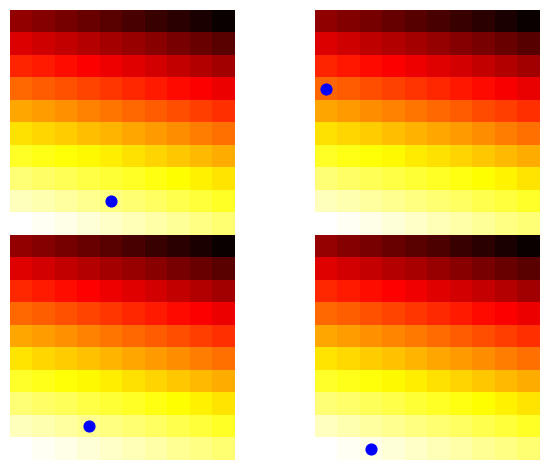


Updates 310, Steps 3980800, FPS 10148
Over the last 10 episodes:
    - episode.reward: 0.12779942150283063
    - episode.score: 0.0
    - episode.distance_to_goal: 0.484236982834764
    - inferred_episode_reward: 12.535938048362732
    - value_loss: 23.418411445617675
    - action_loss: -0.005667792051099241
    - dist_entropy: 5.675747871398926
    - irl_loss: 0.26290314793586733


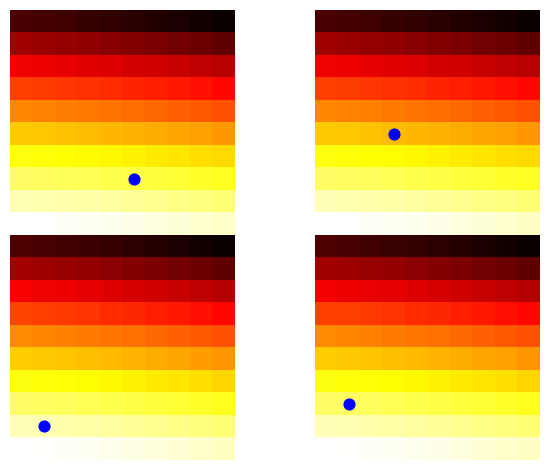


Updates 320, Steps 4108800, FPS 8930
Over the last 10 episodes:
    - episode.reward: 0.390398271370604
    - episode.score: 0.0
    - episode.distance_to_goal: 0.28424676446590613
    - inferred_episode_reward: 21.10179134607315
    - value_loss: 25.840003776550294
    - action_loss: 0.0029086295049637555
    - dist_entropy: 5.675748348236084
    - irl_loss: 0.25992885380983355


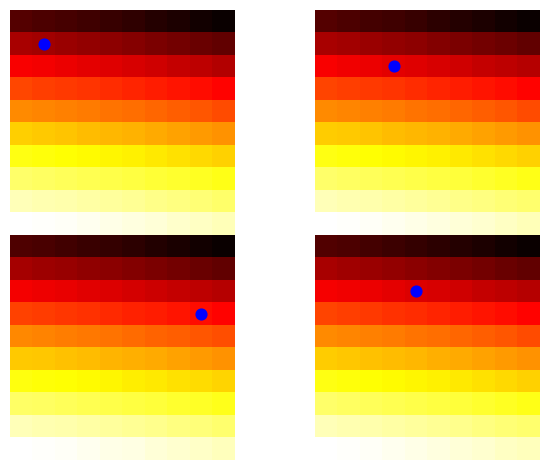


Updates 330, Steps 4236800, FPS 8827
Over the last 10 episodes:
    - episode.reward: 0.34589779404550136
    - episode.score: 0.0
    - episode.distance_to_goal: 0.3822870463033715
    - inferred_episode_reward: 4.552658048272133
    - value_loss: 12.762405014038086
    - action_loss: -6.3361745560541746e-06
    - dist_entropy: 5.674948692321777
    - irl_loss: 0.25681495368480683


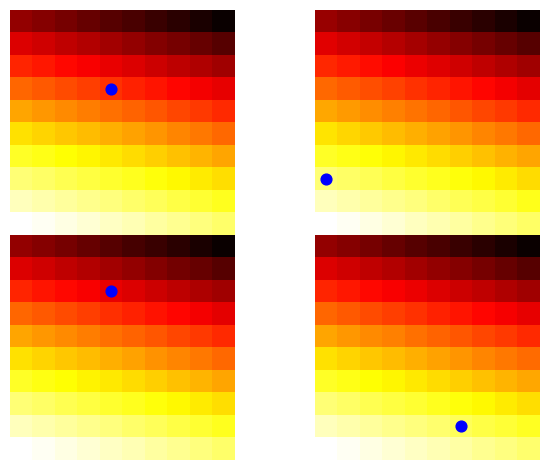


Updates 340, Steps 4364800, FPS 10443
Over the last 10 episodes:
    - episode.reward: 0.29213619445787753
    - episode.score: 0.0
    - episode.distance_to_goal: 0.3807930680126121
    - inferred_episode_reward: 2.271070432662964
    - value_loss: 13.45954933166504
    - action_loss: -0.00691936332732439
    - dist_entropy: 5.6749883651733395
    - irl_loss: 0.26097399592399595


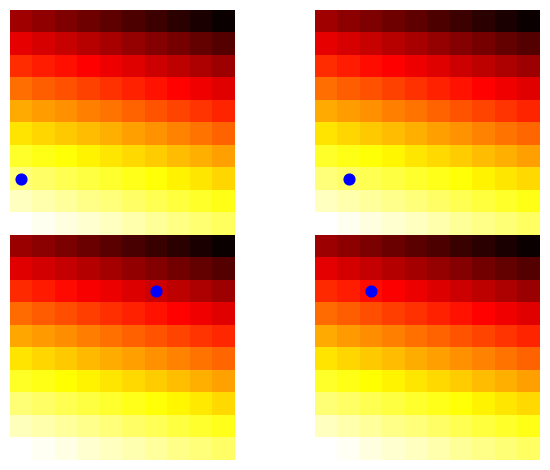


Updates 350, Steps 4492800, FPS 11169
Over the last 10 episodes:
    - episode.reward: 0.20928932188134525
    - episode.score: 0.0
    - episode.distance_to_goal: 0.39723183655030914
    - inferred_episode_reward: 4.336829113960266
    - value_loss: 11.105677890777589
    - action_loss: 0.006153026688843965
    - dist_entropy: 5.67358922958374
    - irl_loss: 0.26579791605472564


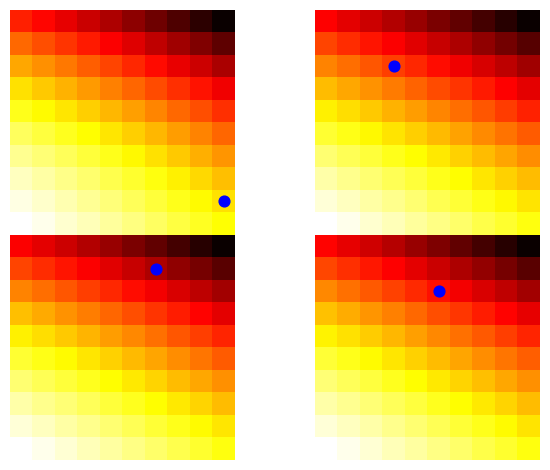


Updates 360, Steps 4620800, FPS 10585
Over the last 10 episodes:
    - episode.reward: -0.11535533905932738
    - episode.score: 0.0
    - episode.distance_to_goal: 0.5371964663346362
    - inferred_episode_reward: 13.469631153345109
    - value_loss: 18.54636421203613
    - action_loss: -0.0008639839594252408
    - dist_entropy: 5.672748565673828
    - irl_loss: 0.264798142015934


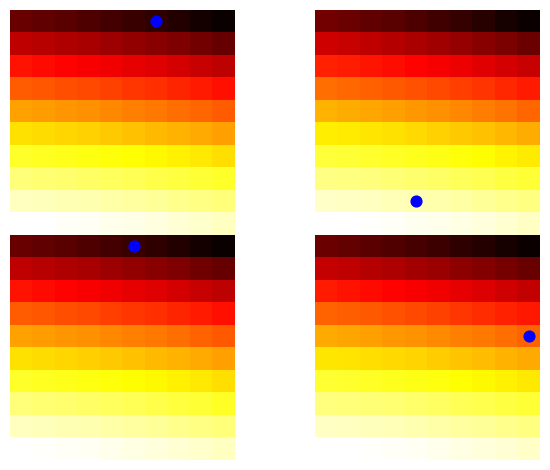


Updates 370, Steps 4748800, FPS 10498
Over the last 10 episodes:
    - episode.reward: 0.36444089009515823
    - episode.score: 0.0
    - episode.distance_to_goal: 0.30999079506975535
    - inferred_episode_reward: 11.908000016212464
    - value_loss: 17.54429473876953
    - action_loss: 0.007180877169594169
    - dist_entropy: 5.6737494468688965
    - irl_loss: 0.26844346821308135


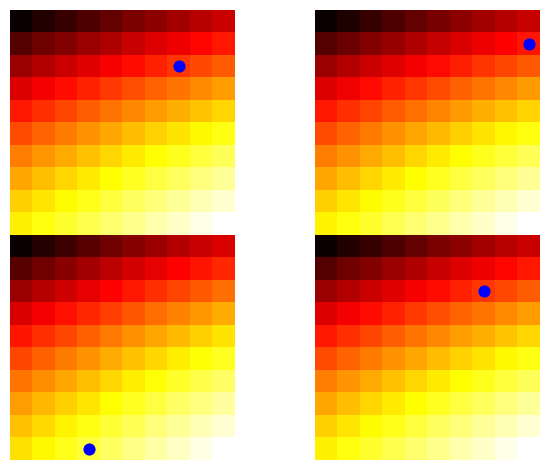


Updates 380, Steps 4876800, FPS 11173
Over the last 10 episodes:
    - episode.reward: 1.2196320370901772
    - episode.score: 0.1
    - episode.distance_to_goal: 0.27647726022380764
    - inferred_episode_reward: 13.961656999588012
    - value_loss: 20.652997970581055
    - action_loss: -0.007948316622059793
    - dist_entropy: 5.674148178100586
    - irl_loss: 0.27761504948139193


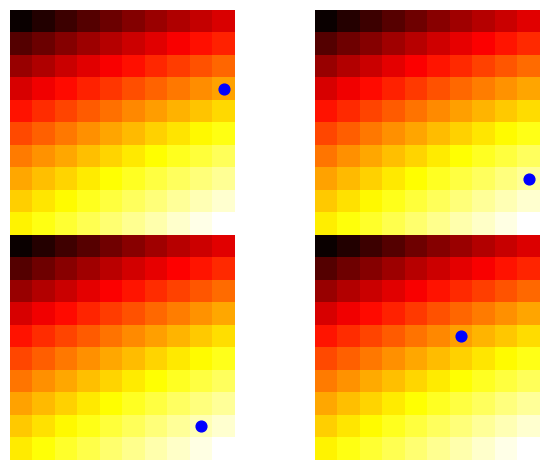


Updates 389, Steps 4992000, FPS 10034
Over the last 10 episodes:
    - episode.reward: 0.3762749444864619
    - episode.score: 0.0
    - episode.distance_to_goal: 0.26753541020526467
    - inferred_episode_reward: 11.333569049835205
    - value_loss: 23.17807788848877
    - action_loss: -0.0022056712536141277
    - dist_entropy: 5.673562049865723
    - irl_loss: 0.2844777196645737


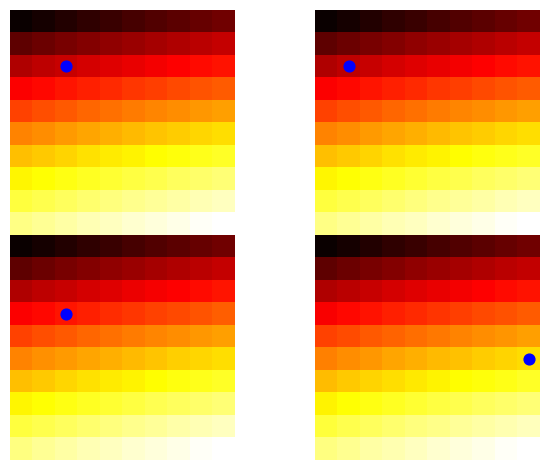

Saved to ./data/checkpoints/63-3-N9wNPS/ckpt.389.pth
{'run_name': '63-3-N9wNPS', 'last_ckpt': './data/checkpoints/63-3-N9wNPS/ckpt.389.pth'}


In [52]:




# Storage for the rollouts
obs = envs.reset()
td = TensorDict({"observation": obs}, batch_size=[cfg.num_envs])
print(td["observation"][0])
# Storage for the rollouts
storage_td = TensorDict({}, batch_size=[cfg.num_envs, cfg.num_steps], device=device)

for update_i in range(start_update, num_updates):
    is_last_update = update_i == num_updates - 1
    for step_idx in range(cfg.num_steps):
        # Collect experience.
        with torch.no_grad():
            policy.act(td)
        next_obs, reward, done, infos = envs.step(td["action"])

        td["next_observation"] = next_obs
        for env_i, info in enumerate(infos):
            if "final_obs" in info:
                td["next_observation"][env_i] = info["final_obs"]
        td["reward"] = reward.reshape(-1, 1)
        td["done"] = done
    
        storage_td[:, step_idx] = td

        # Log to CLI/wandb.
        logger.collect_env_step_info(infos)
    
    # Call method specific update function
    updater.update(policy, storage_td, logger, envs=envs)



    if cfg.log_interval != -1 and (
        update_i % cfg.log_interval == 0 or is_last_update
    ):
        logger.interval_log(update_i, steps_per_update * (update_i + 1))
        height = 2
        width = 2
        eval_env = SnakeEnv(cfg.env.env_settings.params.config)
        fig, ax = plt.subplots(nrows=height, ncols=width, sharex=True, sharey=True, gridspec_kw={'wspace': 0, 'hspace': 0})

        last_reward_map = np.zeros((eval_env.screen_width//eval_env.block_size, eval_env.screen_height//eval_env.block_size))

        for i in range(height):
            for j in range(width):
                
                reward_map = np.zeros((eval_env.screen_width//eval_env.block_size, eval_env.screen_height//eval_env.block_size))
                apple_pos = eval_env.reset()[0][:2]
                #test what you got so far by plotting a heat map of the reward using the snake only 
                for x in range(eval_env.screen_width//eval_env.block_size):
                    for y in range(eval_env.screen_height//eval_env.block_size ):
                        x_grid = x * eval_env.block_size / eval_env.screen_width
                        y_grid = y * eval_env.block_size / eval_env.screen_height
                        reward_map[x,y] = updater.reward(next_obs = torch.tensor([*apple_pos,x_grid,y_grid]+[0]*(eval_env.observation_space.shape[0]-4),dtype=torch.float32).to(device).view(1,1,-1))
                # for x in range(eval_env.screen_width//eval_env.block_size):
                #     for y in range(eval_env.screen_height//eval_env.block_size ):
                #         print(f"{reward_map[x,y]:.2f}", end=" ")
                #     print()
                    
                # Define the color map
                cmap = plt.cm.get_cmap('hot')

                # Plot the reward map without axis and numbers
                image = ax[i,j].imshow(reward_map, cmap=cmap, interpolation='nearest')
                ax[i,j].axis('off')

                # Plot the apple
                ax[i,j].scatter(
                    apple_pos[1] * eval_env.screen_height // eval_env.block_size,
                    apple_pos[0] * eval_env.screen_width // eval_env.block_size,
                    c='blue',
                    s=60
                )
                # map_diff = reward_map - last_reward_map
                # for x in range(eval_env.screen_width//eval_env.block_size):
                #     for y in range(eval_env.screen_height//eval_env.block_size ):
                #          print(f"{reward_map[x,y]:.2f}", end=" ")
                #     print()
                    
                # print("reward_maps diff " ,np.linalg.norm(reward_map-last_reward_map))
                last_reward_map = reward_map
        plt.tight_layout()
        plt.show()
        # for x in range(eval_env.screen_width//eval_env.block_size):
        #     for y in range(eval_env.screen_height//eval_env.block_size ):
        #         print(f"{reward_map[x,y]:.2f}", end=" ")
        #     print()

    if cfg.save_interval != -1 and (
        (update_i + 1) % cfg.save_interval == 0 or is_last_update
    ):
        save_name = osp.join(logger.save_path, f"ckpt.{update_i}.pth")
        torch.save(
            {
                "policy": policy.state_dict(),
                "updater": updater.state_dict(),
                "update_i": update_i,
            },
            save_name,
        )
        print(f"Saved to {save_name}")
        eval_info["last_ckpt"] = save_name

logger.close()
print(eval_info)

In [53]:
ckpt = torch.load(save_name)
updater.load_state_dict(ckpt["updater"], should_load_opt=cfg.resume_training)
policy.load_state_dict(ckpt["policy"])


<All keys matched successfully>

In [54]:
import pygame

In [55]:
cfg.env.env_settings.params.config["render_mode"] = "human"

In [57]:
envs = vectorized_env([SnakeEnv(cfg.env.env_settings.params.config) for _ in range(cfg.num_envs)])

while True:

    obs = envs.reset()
    td = TensorDict({"observation": obs}, batch_size=cfg.num_envs)
    terminated = False 
    while not terminated : 
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                pygame.quit()

        with torch.no_grad():
            policy.act(td)
        next_obs, reward, done, infos = envs.step(td["action"])
        envs.render(mode="human")
        td["next_observation"] = next_obs
        td["reward"] = reward.reshape(-1, 1)

        td["done"] = done

        td["observation"] = next_obs
        terminated = done[0]
        # Log to CLI/wandb.
        logger.collect_env_step_info(infos)
        pygame.time.wait(100)

error: display Surface quit